QATAR MOFA STATEMENTS

https://mofa.gov.qa/en/latest-articles/statements

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup


STEP 1 - Scrape all statements made with Qatari Ministry of Foreign Affairs since 2022

In [ ]:
# ----OPTIONAL: CHECK CHROME DRIVER IS SETUP CORRECTLY----
driver = webdriver.Chrome()
driver.get("https://mofa.gov.qa/en/latest-articles/statements")

In [ ]:
BASE_URL = "https://mofa.gov.qa/en/latest-articles/statements"
CUTOFF_DATE = datetime.now() - timedelta(days=365*2)  # 2 years ago

def scroll_and_collect_links(driver):
    driver.get(BASE_URL)
    time.sleep(3)
    
    seen_links = set()
    collected_data = []
    
    while True:
        soup = BeautifulSoup(driver.page_source, "html.parser")
        items = soup.select("div.news-list-item")
        
        for item in items:
            title_el = item.select_one("h4.news-title")
            date_el = item.select_one("p.news-publication-date")
            link_el = item.find("a")

            if not (title_el and date_el and link_el):
                continue

            date_str = date_el.text.strip()
            pub_date = datetime.strptime(date_str, "%A, %B %d, %Y")
            if pub_date < CUTOFF_DATE:
                return collected_data

            link = link_el["href"]
            if not link.startswith("http"):
                link = "https://mofa.gov.qa" + link

            if link in seen_links:
                continue

            seen_links.add(link)
            collected_data.append({
                "title": title_el.text.strip(),
                "date": pub_date.strftime("%Y-%m-%d"),
                "url": link,
            })

        try:
            load_more = driver.find_element(By.ID, "load-more-statement")
            driver.execute_script("arguments[0].click();", load_more)
            print("🔁 Clicked Load More")
            time.sleep(2)
        except Exception:
            break  # no more "Load More" button

    return collected_data

def scrape_article_text(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        content_div = soup.find("div", class_="news-detail-content")
        if not content_div:
            return ""

        # Prefer paragraphs if present, otherwise use divs
        children = content_div.find_all(["p", "div"], recursive=False)

        if not children:
            return ""

        # Skip the first element (date), get remaining non-empty text
        text_parts = [
            el.get_text(strip=True) for el in children[1:]
            if el.get_text(strip=True)
        ]

        return " ".join(text_parts)

    except Exception as e:
        print(f"❌ Failed to scrape {url}: {e}")
        return ""

In [ ]:
driver = webdriver.Chrome()
print("🔍 Collecting statement links...")
statement_links = scroll_and_collect_links(driver)
print(f"✅ {len(statement_links)} statements found.")

for statement in statement_links:
    print(f"📄 Scraping content: {statement['url']}")
    statement["text"] = scrape_article_text(statement["url"])
    time.sleep(1)  # Be polite with the server

# Create a DataFrame that includes title, URL, date, and full text
df = pd.DataFrame(statement_links)

# Save to Excel
excel_path = "qatar_mofa_statements.xlsx"
sheet_name = 'raw'

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    df.to_excel(writer, sheet_name=sheet_name, index=False)


print(f"📄 Articles saved to {excel_path}")

driver.quit()

Step 2 - Data Analysis

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import _stop_words
from gensim import corpora
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import re

# Custom stopwords
custom_stopwords = set([
    'project', 'include', 'support', 'activities', 'expected', 'providing', 'humanitarian', 'assistance',
    'contributing', 'including', 'increased', 'cfli', 'outcomes', 'projects', 'needs', 'improved',
    'populations', 'people', 'organizations', 'countries', 'affected', 'small', 'international', 'local',
    'human', 'services', 'vulnerable', 'dignity', 'canada', 'aims', 'development', 'persons', 'access',
    'global', 'economic', 'national', 'canadian', 'implementation', 'states', 'capacity', 'acute',
    'outcome', 'million', 'developing', 'action', 'fund', 'united', 'nations', 'funding', '19', 'womenâ',
    'regional', 'priorities', 'red', 'initiatives', 'direct', 'advance', 'strengthen', 'situations',
    'community', 'communities', 'coordination', 'inclusive', 'policy', 'based', 'technical', 'lives',
    'strengthened', 'themes', 'offer', 'focusing', 'provide', 'closely', 'implemented', 'saved', 'ultimate',
    'suffering', 'alleviated', 'maintained', 'experiencing', 'excellency', 'meeting', 'met', 'qna', 'efforts',
    'new', 'york', 'qatar', 'qatars', 'challenges', 'event', 'role', 'highlighted', 'althani', 'alya',
    'ahmed', 'bin', 'cooperation', 'state', 'sheikha', 'saif', 'discussed', 'doha', 'general', 'headquarters',
    'permanent', 'mission', 'republic', 'affairs', 'representative', 'president', 'east', 'world', 'assembly',
    'noted', 'added', 'said', 'thani', 'secretary', 'under', 'joint', 'sides', 'minister', 'expresses', 'al',
    'foreign', 'ministry', 'reiterates', 'importance', 'condolences', 'bilateral', 'dialogue', 'ministers',
    'targeting', 'strategic', 'warns', 'welcomed', 'strongly', 'expressed', 'agreed', 'firm', 'position', 'region',
    'strong', 'welcomes', 'qatari', 'parties','aimed', 'solution', 'reaffirms', 'twostate'
])

texts = df['text']

# Combine the default English stopwords with custom list:
english_stopwords = _stop_words.ENGLISH_STOP_WORDS  # set of default english stopwords
all_stopwords = list(english_stopwords.union(custom_stopwords))

vectorizer = CountVectorizer(
    max_df=0.85, 
    min_df=5, 
    stop_words=all_stopwords
)

Theme Identificiation via Natural Langauge Processing (NLP)

In [70]:
# Topic Identification without bigrams
dtm = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

print_topics(lda, vectorizer.get_feature_names_out(),3)

Topic 0:
['gaza', 'stability', 'security']
Topic 1:
['palestinian', 'jerusalem', 'israeli']
Topic 2:
['palestinian', 'israeli', 'strip']
Topic 3:
['government', 'violence', 'victims']
Topic 4:
['security', 'partnership', 'investment']


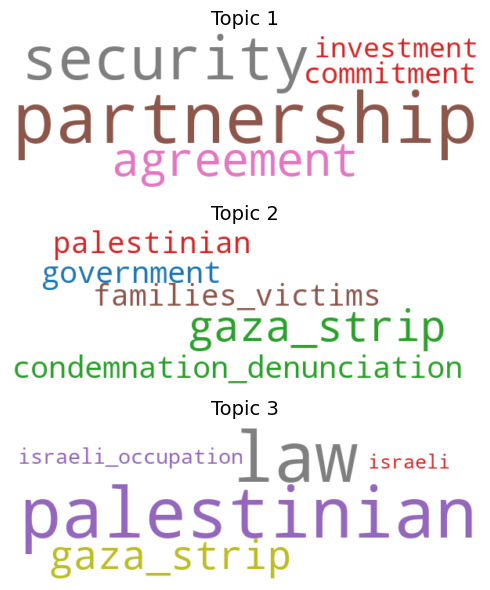

In [71]:
# Topic identification with bigrams
# Text preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in all_stopwords and len(token) > 2]
    return tokens

# Tokenize texts
tokenized_texts = [preprocess(doc) for doc in texts]

# Build bigrams
bigram_model = Phrases(tokenized_texts, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram_model)
texts_with_bigrams = [bigram_phraser[doc] for doc in tokenized_texts]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts_with_bigrams)
dictionary.filter_extremes(no_below=5, no_above=0.75)
corpus = [dictionary.doc2bow(text) for text in texts_with_bigrams]

# Train LDA model with 3 topics
num_topics = 3
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Define figure size in inches for a roughly square layout
fig_width = 6
fig_height = 6

# Each word cloud will have height = fig_height / num_topics
wc_width = int(fig_width * 100)   # 100 dpi
wc_height = int((fig_height / num_topics) * 100)

plt.figure(figsize=(fig_width, fig_height))

for topic_id in range(num_topics):
    plt.subplot(num_topics, 1, topic_id + 1)
    words_probs = dict(lda_model.show_topic(topic_id, topn=5))
    wc = WordCloud(
        width=wc_width,
        height=wc_height,
        background_color='white',
        colormap='tab10',
        prefer_horizontal=0.9,
        min_font_size=15,
    ).generate_from_frequencies(words_probs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id + 1}", fontsize=14)

plt.tight_layout()
plt.show()

In [72]:
# Export Topics Words and Weights to Excel for PowerBI
topic_words = []
num_words = 5  # Adjust based on your needs

for topic_id in range(num_topics):
    words_probs = lda_model.show_topic(topic_id, topn=num_words)
    for word, prob in words_probs:
        topic_words.append({"Topic": topic_id + 1, "Word": word, "Probability": prob})

# Convert to DataFrame
wc = pd.DataFrame(topic_words)

sheet_name = "Topic_WordCloud"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    wc.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to Topic_WordCloud in qatar_mofa_statements.xlsx


Identifying Themes via Keyword Frequency

In [73]:
X = vectorizer.fit_transform(texts)

# Convert to readable DataFrame
X_array = X.toarray()
vocab = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_array, columns=vocab)

# View output
print("Bag of Words Matrix:\n", bow_df.head())

Bag of Words Matrix:
    100  11  12  13  14  16  1701  18  1967  2022  ...  work  workers  working  \
0    0   0   0   0   0   0     0   0     1     0  ...     0        0        0   
1    0   0   0   0   0   0     0   0     0     0  ...     0        0        0   
2    0   0   0   0   0   0     0   0     0     0  ...     0        0        0   
3    0   0   0   0   0   0     0   0     1     0  ...     0        0        0   
4    0   0   0   0   0   0     0   0     0     0  ...     0        0        0   

   works  worldwide  wounded  year  years  yemen  youth  
0      0          0        0     0      0      0      0  
1      0          0        0     0      0      0      0  
2      0          0        0     0      0      0      0  
3      0          0        0     0      0      0      0  
4      0          0        0     0      0      0      0  

[5 rows x 979 columns]


In [74]:
# Sum each word's count across all rows
word_counts = bow_df.sum(axis=0)

# Sort words by frequency (descending)
top_words = word_counts.sort_values(ascending=False)

print("Top words:")
print(top_words.head(20))

Top words:
palestinian    317
security       279
gaza           227
israeli        165
strip          162
stability      154
peace          154
occupation     139
law            130
partnership    115
jerusalem      114
brotherly      112
government     105
agreement      104
capital        103
need            98
commitment      98
rights          97
condemns        94
independent     89
dtype: int64


In [75]:
# Determine the most important words using TF-IDF
# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# To get overall importance of each word across the corpus, sum TF-IDF scores across all documents
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

print("Top Themes by TF-IDF:")
print(word_importance.head(10))

Top Themes by TF-IDF:
palestinian    16.529969
gaza            9.812109
israeli         9.558729
occupation      9.322145
strip           8.904622
security        8.764559
government      7.532531
stability       7.339811
violence        6.922412
jerusalem       6.872379
dtype: float64


AI Tagging

In [7]:
excel_path = "qatar_mofa_statements.xlsx"

In [13]:
tagged = pd.read_excel(excel_path, sheet_name="raw")

tagged.head()

,title,date,url,text,theme_1,theme_2
0,Qatar Condemns Statements by Israeli Minister ...,2025-07-02,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar condemns the statements mad...,Palestinian Conflict,UN and Multilateral Diplomacy
1,Qatar Expresses Full Solidarity with Sudan Aft...,2025-06-30,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar expresses full solidarity w...,Humanitarian Aid,Technology and Innovation
2,Qatar strongly condemns attack on military con...,2025-06-30,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar expresses its strong condem...,Counter-Terrorism and Security,Technology and Innovation
3,Qatar strongly condemns attacks by Israeli set...,2025-06-27,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar strongly condemns the attac...,Palestinian Conflict,UN and Multilateral Diplomacy
4,Qatar Welcomes Ceasefire Agreement between Ira...,2025-06-24,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar welcomes the ceasefire agre...,Peacebuilding and Mediation,Palestinian Conflict


In [14]:
tagged = tagged.melt(
    id_vars = [col for col in tagged.columns if col not in ['theme_1', 'theme_2']],
    value_vars = ['theme_1', 'theme_2'],
    var_name = 'theme_source',
    value_name = 'theme'
)

tagged = tagged.drop(columns=['theme_source'])

tagged['date'] = pd.to_datetime(tagged['date'], errors='coerce')
tagged['year'] = tagged['date'].dt.year

tagged.head()

,title,date,url,text,theme,year
0,Qatar Condemns Statements by Israeli Minister ...,2025-07-02,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar condemns the statements mad...,Palestinian Conflict,2025
1,Qatar Expresses Full Solidarity with Sudan Aft...,2025-06-30,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar expresses full solidarity w...,Humanitarian Aid,2025
2,Qatar strongly condemns attack on military con...,2025-06-30,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar expresses its strong condem...,Counter-Terrorism and Security,2025
3,Qatar strongly condemns attacks by Israeli set...,2025-06-27,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar strongly condemns the attac...,Palestinian Conflict,2025
4,Qatar Welcomes Ceasefire Agreement between Ira...,2025-06-24,https://mofa.gov.qa/en/latest-articles/stateme...,The State of Qatar welcomes the ceasefire agre...,Peacebuilding and Mediation,2025


In [15]:
sheet_name = "tagging"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    tagged.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to tagging in qatar_mofa_statements.xlsx
